<a href="https://colab.research.google.com/github/bruno-raffa/Quantum-exercises/blob/main/JSS_(Job_Shop_Scheduling).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook is a small readaptation of the so called Job Scheduling Problem (JSS). [Dwave-JSS](https://github.com/dwave-examples/job-shop-scheduling-cqm)

In [ ]:
! pip install dwave-ocean-sdk
! dwave setup

In [2]:
import matplotlib
import numpy as np
from dimod import ConstrainedQuadraticModel, BinaryQuadraticModel, QuadraticModel, Binary, quicksum, Integer


from dwave.system import LeapHybridCQMSampler
import pandas as pd
import urllib.request
from collections import defaultdict

try:
    import matplotlib.pyplot as plt
except ImportError:
    matplotlib.use("agg")

In [3]:
def read_scenario(file_name):
    """A method that reads input instance file
    Args:
        instance_path:  path to the job shop instance file
    Returns:
        Job_dict: dictionary containing jobs as keys and a list of tuple of
                machines and their processing time as values.
    """
    job_dict = defaultdict(list)
    lines = urllib.request.urlopen(file_name)
    for i, line in enumerate(lines):
      info = line.decode('utf-8')
      if i == 0:
        num_jobs = int(line.split()[-1])
      elif i == 1:
          num_machines = int(line.split()[-1])
      elif 2 <= i <= 4:
          continue
      else:
        job_task = list(map(int, line.split()))
        job_dict[i - 5] = [x for x in
                            zip(job_task[1::2],  # machines
                                job_task[2::2]  # processing duration
                                )]
    return job_dict    

In [4]:
max_makespan = 0
jobtask_duration = {}
jobtask_in_machine = {}
jobmachine_executes_task = {}

In [5]:
filename = 'https://raw.githubusercontent.com/dwave-examples/job-shop-scheduling-cqm/main/input/instance5_8.txt'
jobs = read_scenario(filename)

In [6]:
for j, val in jobs.items():
  for i, (machine, duration) in enumerate(val):
    jobtask_in_machine[(j, i)] = machine
    jobtask_duration[(j, i)] = duration
    jobmachine_executes_task[(j, machine)] = i

In [7]:
num_jobs = len(jobs)
num_machines = len(jobs[0])
# Calculate a trivial upper bound for make span
max_makespan = sum(jobtask_duration[(j, i)]
                        for j in range(num_jobs) for i in
                        range(num_machines))

In [8]:
x = {}
y = {}
makespan = {}
best_sample = {}
solution = {}
completion_time = 0

In [9]:
# Define make span as an integer variable
makespan = Integer("makespan", lower_bound=0,
                               upper_bound=max_makespan)

# Define integer variable for start time of using machine i for job j
x = {
    (j, i): Integer('x{}_{}'.format(j, i), lower_bound=0,
                    upper_bound=max_makespan)
    for j in range(num_jobs) for i in range(num_machines)}

 # Add binary variable which equals to 1 if job j precedes job k on machine i
y = {(j, k, i): Binary('y{}_{}_{}'.format(j, k, i))
                  for j in range(num_jobs)
                  for k in range(num_jobs) for i in
                  range(num_machines)}

In [10]:
cqm = ConstrainedQuadraticModel()
cqm.set_objective(makespan)

#  Constraint 1 : Ensures that the make span is at least the largest completion time of
        #the last operation of all jobs.
for j in range(num_jobs):
  last_machine = jobtask_in_machine[(j, num_machines - 1)]
  cqm.add_constraint(
      makespan - x[(j, last_machine)] >=
      jobtask_duration[(j, num_machines - 1)],
      label='makespan_ctr{}'.format(j))
  
#   Constraint 2: Precedence constraints ensures that all operations of a job are
       #  executed in the given order

for j in range(num_jobs):  # job
  for t in range(1, num_machines):  # tasks
      machine_curr = jobtask_in_machine[(j, t)]
      machine_prev = jobtask_in_machine[(j, t - 1)]
      cqm.add_constraint(x[(j, machine_curr)] -
            x[(j, machine_prev)]>= jobtask_duration[(j, t - 1)],
                              label='pj{}_m{}'.format(j, t)
                              )
      

#  Constraint 3: Add quadratic constraints to ensure that no two jobs can be scheduled
         #on the same machine at the same time

for j in range(num_jobs):
  for k in range(num_jobs):
      if j < k:
          for i in range(num_machines):
              task_k = jobmachine_executes_task[(k, i)]
              task_j = jobmachine_executes_task[(j, i)]
              if jobtask_duration[k, task_k] > 0 and\
                      jobtask_duration[j, task_j] > 0:
                  cqm.add_constraint(
                      x[(j, i)] - x[(k, i)] + (
                              jobtask_duration[k, task_k] -
                              jobtask_duration[
                                  j, task_j]) * y[
                          (j, k, i)] + 2 * y[(j, k, i)] * (
                              x[(k, i)] - x[(j, i)]) >=
                      jobtask_duration[(k, task_k)],
                      label='OneJobj{}_j{}_m{}'.format(j, k, i))


In [20]:
sampler = LeapHybridCQMSampler()
raw_sampleset = sampler.sample_cqm(cqm)
feasible_sampleset = raw_sampleset.filter(lambda d: d.is_feasible)
num_feasible = len(feasible_sampleset)
if num_feasible > 0:
    best_samples = \
        feasible_sampleset.truncate(min(10, num_feasible))
else:
    warnings.warn("Warning: Did not find feasible solution")
    best_samples = raw_sampleset.truncate(10)

print(" \n" + "=" * 30 + "BEST SAMPLE SET" + "=" * 30)

best_sample = best_samples.first.sample
#print(best_sample)


 
==============================BEST SAMPLE SET==============================


In [21]:
solution = {
            (j, i): (jobmachine_executes_task[(j, i)],
                     best_sample[x[(j, i)].variables[0]],
                     jobtask_duration[(j, jobmachine_executes_task[(j, i)])])
            for i in range(num_machines) for j in range(num_jobs)}

completion_time = best_sample['makespan']
completion_time

72.0

In [14]:
def plot_solution(solution: dict) -> tuple:
    """Prepare Jss solution for plotting
    Args:
        data: JSS data class
        solution: a dictionary of solution
        location: path for saving scheduling plot
    """
    job_start_time = defaultdict(list)
    processing_time = defaultdict(list)
    for j in range(num_jobs):
        job_start_time[j] = [solution[(j, i)][1] for i in
                             range(num_machines)]
        processing_time[j] = [
            jobtask_duration[j, jobmachine_executes_task[(j, i)]] for i in
            range(num_machines)]
    
    plot_schedule_core(job_start_time, processing_time)
    return job_start_time, processing_time

In [15]:
def plot_schedule_core(job_start_time: dict, processing_time: dict,) -> None:
    """This function plots job shop problem
    Args:
        job_start_time: start time of each job on each machine
        processing_time: processing duration of each job on each machine
        location: path for saving scheduling plot
    """

    sols = np.array(list(job_start_time.values()))
    durs = np.array(list(processing_time.values()))
    solsT = sols.transpose()
    dursT = durs.transpose()
    n, m = sols.shape
    labels = ['machine ' + str(i) for i in range(m)]
    category_names = ['job ' + str(i) for i in range(n)]

    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.15, 0.85, sols.shape[0]))
    fig, ax = plt.subplots()
    ax.invert_yaxis()
    ax.xaxis.set_visible(True)

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = dursT[:, i]
        starts = solsT[:, i]
        ax.barh(labels, widths, left=starts, height=.5,
                label=colname)
        xcenters = starts + widths / 2
        r, g, b, _ = color
        text_color = 'white'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            if c > 0:
                ax.text(x, y, str(int(c)), ha='center', va='center',
                        color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    plt.draw()



(defaultdict(list,
             {0: [40.0, 48.0, 10.0, 26.0, 19.0, 48.0, 72.0, 58.0],
              1: [33.0, 72.0, 19.0, 1.0, 62.0, 52.0, 66.0, 37.0],
              2: [61.0, 40.0, 0.0, 71.0, 52.0, 48.0, 73.0, 66.0],
              3: [7.0, 26.0, 22.0, 12.0, 68.0, 39.0, 33.0, 3.0],
              4: [24.0, 0.0, 43.0, 6.0, 0.0, 12.0, 62.0, 50.0]}),
 defaultdict(list,
             {0: [8, 10, 9, 10, 1, 0, 1, 8],
              1: [3, 0, 3, 5, 4, 10, 6, 7],
              2: [5, 6, 10, 1, 9, 4, 1, 5],
              3: [4, 7, 4, 10, 6, 9, 6, 3],
              4: [7, 6, 7, 6, 0, 8, 1, 3]}))

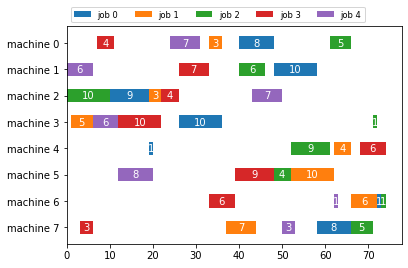

In [18]:
plot_solution(solution)
